In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import cv2
import numpy as np
from os import listdir as ld
from os.path import join as pj
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data

# Dataset
from dataset.detection.dataset import insects_dataset_from_voc_style_txt, collate_fn
from IO.build_ds import build_classification_ds_from_result
# Loader
from IO.loader import load_path, load_images, load_annotations_path, load_annotations, get_anno_recs
# Predict
from model.refinedet.utils.predict import test_prediction as test_detection
from model.resnet.predict import test_classification
# utils
from IO.utils import refine_result_by_ovthresh
# Evaluate
from evaluation.det2cls.evaluate import evaluate, get_cls_accuracy_per_class
# Visualize
from evaluation.detection.visualize import plot_pr_curve
from evaluation.det2cls.visualize import vis_detections

# Test Config

In [3]:
class args:
    # paths
    data_root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
    test_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_refined_images"
    det_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", "crop_b2_2_4_8_16_32_im512")
    divide_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", "resnet101_b20_r45_lr1e-5_crossvalid_divide_resize")
    cls_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", "resnet50_b20_r45_lr1e-5_crossvalid_other_without_grouping")
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/det2cls/RefineDet_ResNet", "refinedet_resnet50_resnet101_param1_aaaaa")
    test_anno_folders = ["annotations_4"]
    # training config
    div_model_name = "ResNet101"
    cls_model_name = "ResNet50"
    input_size = 512 # choices=[320, 512, 1024]
    crop_num = (5, 5)
    tcb_layer_num = 5
    rm_last = True
    # test config
    save_fig = True
    save_df = True
    # class label
    div_labels =  ['Aquatic_insects', 'Other_insects']
    #cls_labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
    #               'Lepidoptera', 'Plecoptera', 'Trichoptera']
    cls_labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                   'Lepidoptera', 'Plecoptera', 'Trichoptera', 
                   'Coleoptera', 'Hemiptera', 'medium insect', 'small insect']

# Model Config

In [4]:
if args.tcb_layer_num == 4 and args.rm_last == False:
    from model.refinedet.config import tcb_4_rm_false as insect_refinedet
elif args.tcb_layer_num == 4 and args.rm_last == True:
    from model.refinedet.config import tcb_4_rm_true as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == False:
    from model.refinedet.config import tcb_5_rm_false as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == True:
    from model.refinedet.config import tcb_5_rm_true as insect_refinedet
elif args.tcb_layer_num == 6 and args.rm_last == False:
    from model.refinedet.config import tcb_6_rm_false as insect_refinedet

# Set cuda

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# Detection Model

In [6]:
if args.rm_last == True:
    from model.refinedet.refinedet_rmlast import build_refinedet
else:
    from model.refinedet.refinedet import build_refinedet

In [7]:
det_model = build_refinedet('test', insect_refinedet, args.input_size, args.tcb_layer_num).cuda()
load_name = pj(args.det_model_root, 'RefineDet{}_{}.pth'.format(args.input_size, "final"))
det_model.load_state_dict(torch.load(load_name))

# Aquatic insect Classifier

In [8]:
if args.div_model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
    div_model = ResNet18(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
    div_model = ResNet34(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
    div_model = ResNet50(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
    div_model = ResNet101(len(args.div_labels)).cuda()
else:
    print("error! write correct model name!")
div_model.load_state_dict(torch.load(pj(args.divide_model_root, "final.pth")))

# Classification Model

In [9]:
if args.cls_model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
    cls_model = ResNet18(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
    cls_model = ResNet34(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
    cls_model = ResNet50(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
    cls_model = ResNet101(len(args.cls_labels)).cuda()
else:
    print("error! write correct model name!")
cls_model.load_state_dict(torch.load(pj(args.cls_model_root, "final.pth")))

### Make data

In [10]:
print('Loading dataset for test ...')
test_dataset = insects_dataset_from_voc_style_txt(args.test_image_root, args.input_size, args.crop_num, "RefineDet", training=False)
test_data_loader = data.DataLoader(test_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)
print('Loading annotation for test...')
annos, imgs = load_path(args.data_root, "refined_images", args.test_anno_folders)
images = load_images(imgs)
annotations_path = load_annotations_path(annos, images)
anno = load_annotations(annotations_path)
imagenames, recs = get_anno_recs(anno)

Loading dataset for test ...
Loading annotation for test...


### Get refinedet config

In [11]:
cfg = insect_refinedet[str(args.input_size)]

# --- result analysis ---

In [12]:
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [13]:
result = test_detection(det_model, test_data_loader, args.crop_num, nms_thresh=0.3)

In [14]:
result = refine_result_by_ovthresh(result, ovthresh=0.3)

In [15]:
insect_dataset = build_classification_ds_from_result(images, result, use_resize=False)

In [16]:
for image_id, imgs in insect_dataset.items():
    imgs = torch.from_numpy(imgs).cuda()
    cls_lbls = test_classification(cls_model, imgs, bs=20)
    divide_lbls = test_classification(div_model, imgs, bs=20)
    result[image_id].update({"output_lbl": cls_lbls})
    result[image_id].update({"divide_lbl": divide_lbls})

- cls only without grouping

In [17]:
cls_lbl_dic = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:6, 8:6, 9:6}

In [18]:
for image_id, imgs in insect_dataset.items():
    imgs = torch.from_numpy(imgs).cuda()
    cls_lbls = test_classification(cls_model, imgs, bs=20)
    divide_lbls = test_classification(div_model, imgs, bs=20)
    cls_lbls = np.asarray([cls_lbl_dic[lbl] for lbl in cls_lbls])
    result[image_id].update({"output_lbl": cls_lbls})
    result[image_id].update({"divide_lbl": divide_lbls})

In [19]:
# arrange index to label
# not considered label = -1
name2lbl = {
    'Coleoptera': 6, 
    'Diptera': 0, 
    'Ephemeridae': 1, 
    'Ephemeroptera': 2, 
    'Hemiptera': 6, 
    'Lepidoptera': 3, 
    'Plecoptera': 4, 
    'Trichoptera': 5, 
    'medium insect': 6, 
    'small insect': 6, 
    'snail': 6, 
    'spider': 6
}

In [20]:
recall, precision, avg_precision, gt_dict = evaluate(result, recs, name2lbl, 0.3)

### --- visualize accuracy distribution of size ---

- cls only without grouping

In [21]:
df = pd.DataFrame({"precision": precision, "recall": recall})
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "pr_curve_df.csv"))
df

,precision,recall
0,0.001605,1.000000
1,0.003210,1.000000
2,0.004815,1.000000
3,0.006421,1.000000
4,0.008026,1.000000
...,...,...
635,0.598716,0.586478
636,0.600321,0.587127
637,0.600321,0.586207
638,0.600321,0.585290


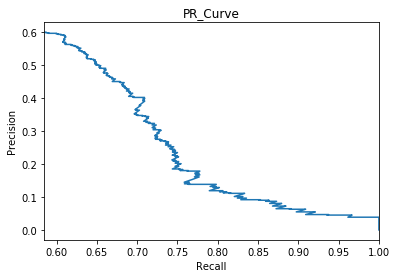

In [22]:
plot_pr_curve(df, args.figure_root, save=args.save_fig)

### --- visualize cls accuracy ---

- cls only without grouping

In [23]:
accs, recalls, precisions = get_cls_accuracy_per_class(result, gt_dict, name2lbl, add_divide_model=False)

In [24]:
np.mean(accs)

0.7417250853819335

In [25]:
np.mean(recalls)

0.8011025265057522

In [26]:
np.mean(precisions)

0.7671935520619731

In [27]:
accs

[0.8620689655172413,
 0.7142857142857143,
 0.6666666666666666,
 0.7777777777777778,
 0.8333333333333334,
 0.7777777777777778,
 0.75,
 0.6363636363636364,
 0.5294117647058824,
 0.8695652173913043]

In [28]:
recalls

array([0.72727273, 0.76923077, 0.67741935, 0.825     , 1.        ,
       0.80769231])

In [29]:
precisions

array([0.71428571, 1.        , 0.6       , 0.86842105, 0.54545455,
       0.875     ])

### --- compare ground truth and output ---

In [ ]:
add_divide_model = False
n_class_when_not_use_divide_model = 7

In [ ]:
im_index = 0
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [ ]:
colors = ["white", "red", "lime", "blue", "yellow", "fuchsia", "aqua", "gray", "maroon", "green", "navy", "olive", "purple", "teal"]
insect_name =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 'Lepidoptera', 'Plecoptera', 'Trichoptera']
# arrange index to label
# not considered label = -1
# to see ground truth, use medium and small label
name2lbl = {
    'Coleoptera': 6, 
    'Diptera': 0, 
    'Ephemeridae': 1, 
    'Ephemeroptera': 2, 
    'Hemiptera': 6, 
    'Lepidoptera': 3, 
    'Plecoptera': 4, 
    'Trichoptera': 5, 
    'medium insect': 6, 
    'small insect': 6, 
    'snail': 6, 
    'spider': 6
}

In [ ]:
img = np.asarray(Image.open(pj("/home/tanida/workspace/Insect_Phenology_Detector/data/refined_images", imagenames[im_index]+".png")))
out = result[imagenames[im_index]]["output_lbl"]
if add_divide_model is True:
    out = np.asarray([output for i, output in enumerate(out) if result[imagenames[im_index]]["divide_lbl"][i] == 0])
    result_coord = np.asarray([coord for i, coord in enumerate(result[imagenames[im_index]]['coord']) if result[imagenames[im_index]]["divide_lbl"][i] == 0])
else:
    out_mask = out == (n_class_when_not_use_divide_model - 1)
    out = np.asarray([output for i, output in enumerate(out) if out_mask[i] == False])
    result_coord = np.asarray([coord for i, coord in enumerate(result[imagenames[im_index]]['coord']) if out_mask[i] == False])

for i in range(len(insect_name)):
    lbl_filter = out == i
    result_coord_filtered_by_lbl = result_coord[lbl_filter]
    gt_lbls = np.asarray([name2lbl[name] for name in gt_dict[imagenames[im_index]]['default_name']])
    lbl_filter = gt_lbls == i
    gt_coord_filtered_by_lbl = gt_dict[imagenames[im_index]]['bbox'][lbl_filter]
    
    img = vis_detections(img, result_coord_filtered_by_lbl, class_name=insect_name[i], color_name=colors[i])
    img = vis_detections(img, gt_coord_filtered_by_lbl, class_name=insect_name[i], color_name=colors[i])

img = Image.fromarray(img)
img.save(pj(args.figure_root, imagenames[im_index]+".png"))
print(imagenames[im_index])
im_index += 1